# Minichallenge 2 Deep Learning

In [107]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from IPython.display import display, HTML
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Einleitung

In dieser Minichallenge wird eine Kombination von neuronalen Netzen aufgebaut, die am Ende im Stande sein soll, Bilder mit Captions zu versehen. Für das Training wurden das flickr8k-Datenset verwendet, welches unter https://www.kaggle.com/sakshighadigaonkar/flickr-8k/download erhältlich ist. Das Ziel dieser Challenge ist es Resultate vom folgenden Paper zu reproduzieren: https://arxiv.org/pdf/1411.4555.pdf

# Explorative Datenanalyse & Preprocessing
In diesem Kapitel geht es darum, ein Gefühl für die Datenlage zu bekommen. 

## Zufällige Inspektion der Bilder und Captions

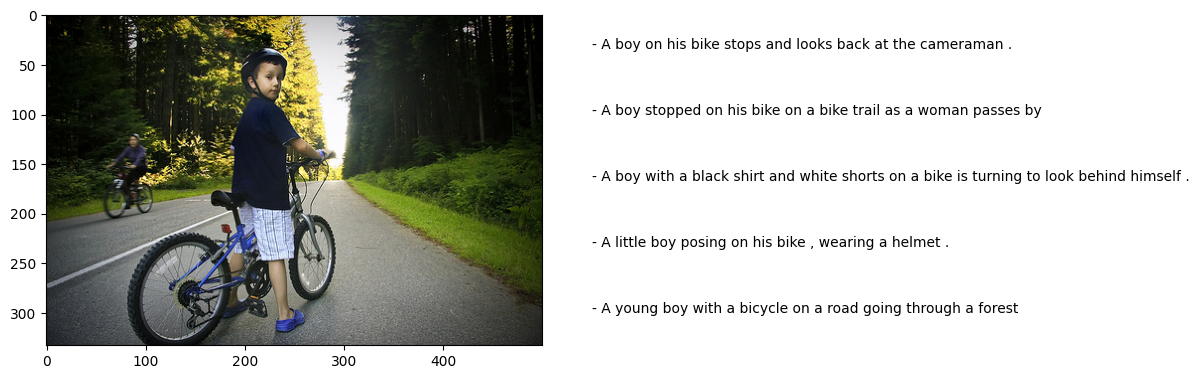

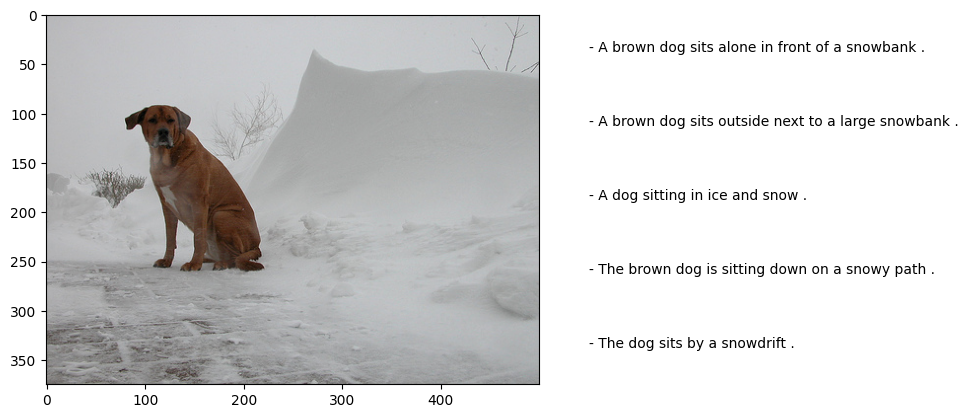

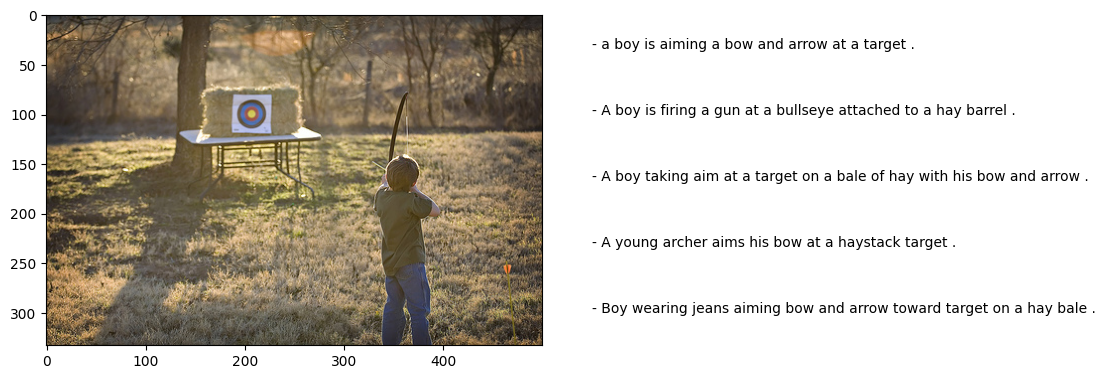

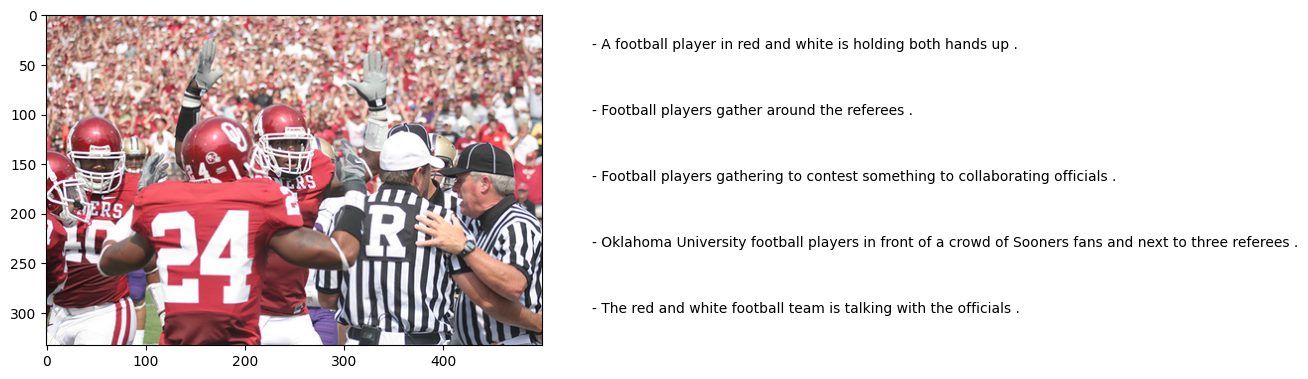

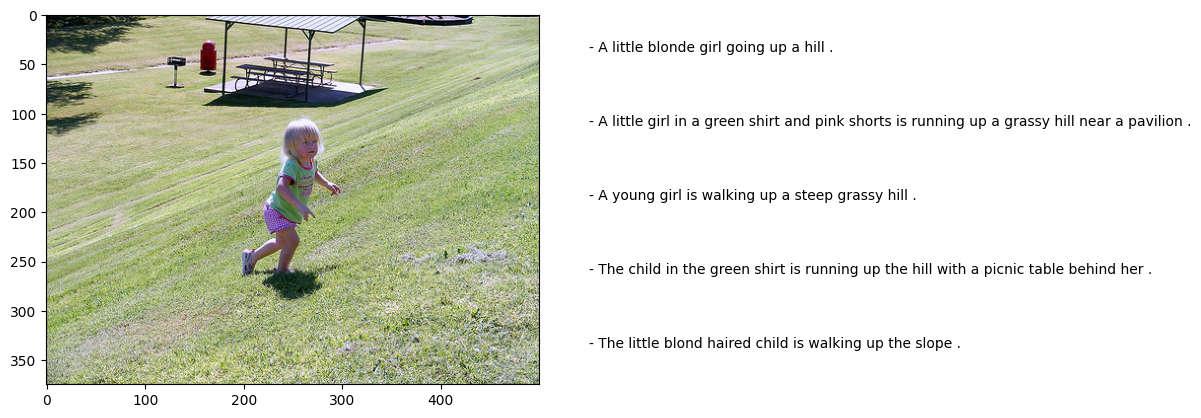

In [2]:
captions = pd.read_csv('flickr8k/captions.txt')

# set numpy seed
np.random.seed(21)

# plot 5 random images with their captions
for i in range(5):
    idx = np.random.randint(0, len(captions))
    img = plt.imread('flickr8k/images/' + captions.iloc[idx, 0])
    plt.imshow(img)

    image_captions = captions[captions.image == captions.iloc[idx, 0]].caption.values
    for i, caption in enumerate(image_captions):
        plt.text(x=img.shape[1] + (img.shape[1] / 10), y=((img.shape[0] / 10) * 2 * i) + (img.shape[0] / 10), s="- " + caption)
    plt.show()

Ich würde die meisten Captions als zutreffend beschreiben. Auffallend ist jedoch, wie stark sich die Genauigkeit der Captions unterscheidet. 

Ein Beispiel ist das Bild, welches die Diskussion zwischen Footballspielern und Schiedsrichter abbildet. Eine Caption lautet:<br><q>Oklahoma University football players in front of a crowd of Sooners fans and next to three referees.</q> Zwar stimmt diese Aussage, sie ist aber extrem detailliert. Dazu muss erkennt werden, dass es sich um Spieler und Fans der Oklahoma University handelt. Dann müsste unser Modell eigentlich jede Footballmannschaft erkennen, anhand eines kleinen Schriftzuges auf dem Bild. Dies ist natürlich eine unrealistische Vorstellung. Diese Captions helfen unserem Modell nicht, bessere Ergebnisse zu erreichen.

Zudem hat es auch eine falsche Caption in diesen fünf Samples. Das Bild, welches den Jungen mit Pfeil und Bogen zeigt, hat eine Caption die sagt: <q>A boy is firing a gun at bullseye attached to a hay barrel.</q> Dies ist natürlich falsch, da es sich nicht um ein Gewehr, sondern um einen Bogen handelt. Zudem ist es kein "Hay Barrel" sondern ein "Hay Bales". 

## Textdaten

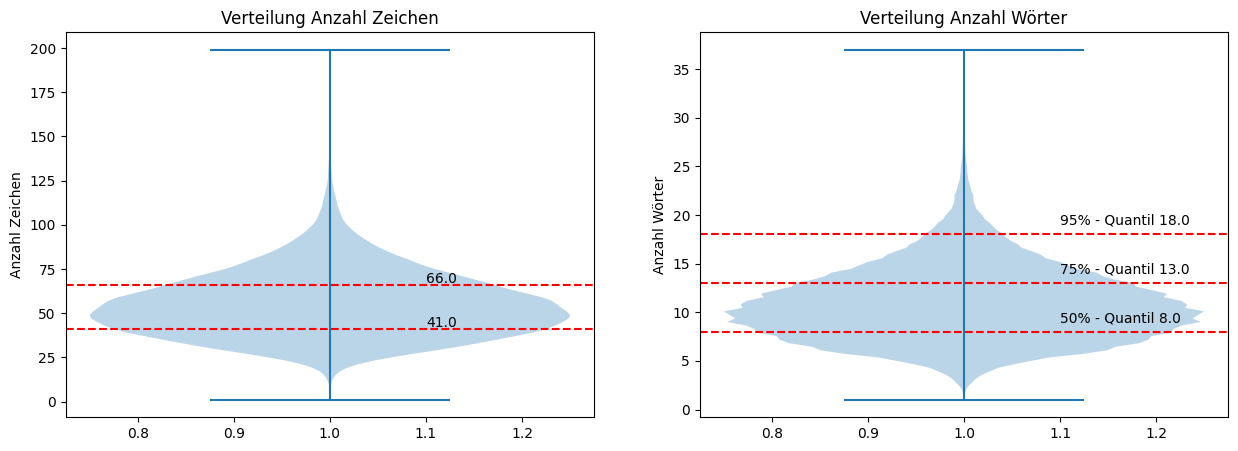

In [3]:
n_characters = []
n_words = []

for caption in captions.caption.values:
    n_characters.append(len(caption))
    n_words.append(len(caption.rstrip(" .").split(" ")))

# create subplots 2x1
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# violin plot for number of characters
ax[0].violinplot(n_characters)
ax[0].set_title("Verteilung Anzahl Zeichen")
ax[0].set_ylabel("Anzahl Zeichen")

# add lines for 25th and 75th percentile
ax[0].axhline(np.percentile(n_characters, 25), color='r', linestyle='--')
ax[0].axhline(np.percentile(n_characters, 75), color='r', linestyle='--')

# show 25th and 75th percentile as text
ax[0].text(1.1, np.percentile(n_characters, 25) + 1, str(np.percentile(n_characters, 25)))
ax[0].text(1.1, np.percentile(n_characters, 75) + 1, str(np.percentile(n_characters, 75)))

# violin plot for number of words
ax[1].violinplot(n_words)
ax[1].set_title("Verteilung Anzahl Wörter")
ax[1].set_ylabel("Anzahl Wörter")

# add lines for 25th and 75th percentile
ax[1].axhline(np.percentile(n_words, 25), color='r', linestyle='--')
ax[1].axhline(np.percentile(n_words, 75), color='r', linestyle='--')
ax[1].axhline(np.percentile(n_words, 95), color='r', linestyle='--')

# show 25th and 75th percentile as text
ax[1].text(1.1, np.percentile(n_words, 25) + 1, "50% - Quantil " + str(np.percentile(n_words, 25)))
ax[1].text(1.1, np.percentile(n_words, 75) + 1, "75% - Quantil " + str(np.percentile(n_words, 75)))
ax[1].text(1.1, np.percentile(n_words, 95) + 1, "95% - Quantil " + str(np.percentile(n_words, 95)))


plt.show()

Die Hälfte aller Captions hat eine Länge zwischen 8 und 13 Wörtern. 95% aller Captions haben Captions mit weniger als 18 Wörtern. Dies ist die Region, bei der die Grenze der Länge der Captions gesetzt werden kann. 

Maximale Anzahl Wörter:  20.0
Minimale Anzahl Wörter:  3.0
95% - Quantil 15.0
50% - Quantil 10.0
Median:  10.0


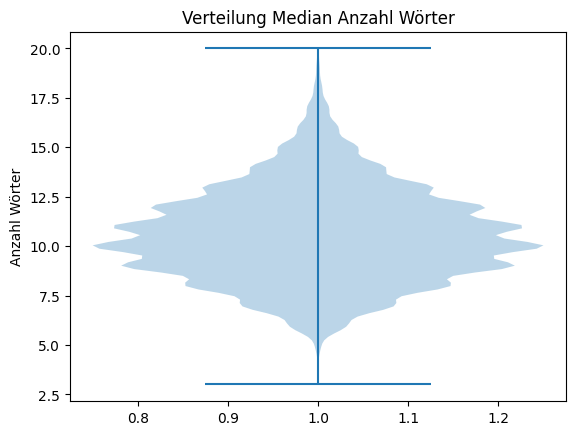

In [4]:
# select only shortest caption per image
captions['caption_word_length'] = captions.caption.apply(lambda x: len(x.rstrip(" .").split(" ")))
median_calc = captions.groupby('image').median('caption_word_length')
# print max and min values
print("Maximale Anzahl Wörter: ", median_calc.caption_word_length.max())
print("Minimale Anzahl Wörter: ", median_calc.caption_word_length.min())
print("95% - Quantil", median_calc.caption_word_length.quantile(0.95))
print("50% - Quantil", median_calc.caption_word_length.quantile(0.5))
print("Median: ", median_calc.caption_word_length.median())
# violinplot for caption length
plt.violinplot(median_calc.caption_word_length)
plt.title("Verteilung Median Anzahl Wörter")
plt.ylabel("Anzahl Wörter")
plt.show()

Der Median der Captionlänge pro Bild beträgt 10 Wörter. 100% aller Bilder haben mehr als eine Caption mit einer Länge unter 20 Wörtern. ie Captionlänge 20 wird gewählt, um die Länge der Captions zu begrenzen.

In [5]:
print("Shape captions:", captions.shape)
# filter captions with less or equal to 20 words
captions_filtered = captions[captions.caption_word_length <= 20]
print("Shape captions after filtering:", captions_filtered.shape)
print("Removed Captions: ", captions.shape[0] - captions_filtered.shape[0], ", in Percent: ", round(((captions.shape[0] - captions_filtered.shape[0]) / captions.shape[0]) * 100, 2))

Shape captions: (40455, 3)
Shape captions after filtering: (39744, 3)
Removed Captions:  711 , in Percent:  1.76


Durch diese Begrenzung wurden 711 Captions entfernt. Dies entspricht 1.76% aller Captions.

### Preprocessing der Textdaten

Die Textdaten müssen vorverarbeitet werden. Es werden alle Wörter in Kleinbuchstaben geschrieben, Satzzeichen entfernt und Wörter wie "isn't" zu "is not" umgewandelt. Zuerst wird aber überprüft ob dies überhaupt notwendig ist. 

Ein weiterer, wichtiger Schritt für den Aufbau des Modells ist die Bestimmung der Satzlänge. Das Netzwerk benötigt eine fixe Satzlänge für die Eingabe. Kürzere Sätze werden mit einem sogenannten Padding-Token gefüllt (```<pad>```). Längere Sätze werden abgeschnitten. Oben wurde bereits die Länge der Captions auf 20 Wörter begrenzt.

#### Entfernung von speziellen Zeichen

In [6]:
import string
from torchtext.data.utils import get_tokenizer

In [7]:
print(captions_filtered.shape)
# remove all punctuation
captions_filtered.caption = captions_filtered.caption.apply(lambda x: x.strip("."))
captions_filtered = captions_filtered.dropna()
captions_filtered.caption = captions_filtered.caption.apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))
captions_filtered = captions_filtered.dropna()
print(captions_filtered.shape)

(39744, 3)
(39744, 3)


/var/folders/9d/4tljkqh948z6_bfh9n2f6qnr0000gn/T/ipykernel_23300/2356385433.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  captions_filtered.caption = captions_filtered.caption.apply(lambda x: x.strip("."))


#### Tokenisierung

In [8]:
# set tokens
sos_token = "<SOS>" # start of sentence token
eos_token = "<EOS>" # end of sentence token
pad_token = "<PAD>" # padding token
unk_token = "<UNK>" # unknown word token

def tokenize_captions(captions:pd.DataFrame, caption_length:int):
    # create tokenizer
    tokenizer = get_tokenizer('basic_english')

    # create vocabulary
    vocabulary = set()
    for i, caption in enumerate(captions.values):
        # tokenize caption
        tokenized = tokenizer(caption[1])

        # cut off tokenized caption at caption_length
        tokenized = tokenized[:caption_length]
        
        # update vocabulary
        vocabulary.update(tokenized)

        # add tokens
        tokenized = [sos_token] + tokenized + [eos_token]
        
        if len(tokenized) < caption_length + 2:
            tokenized += [pad_token] * (caption_length + 2 - len(tokenized))

        
        # tokenize caption
        captions.iloc[i, 1] = str(tokenized)

    return captions, vocabulary

# tokenize captions
captions_filtered, vocabulary = tokenize_captions(captions_filtered, 20)

In [9]:
for caption in captions_filtered.caption.values:
    # turn string into list
    caption = eval(caption)
    # check caption length
    assert len(caption) == 22
    assert sos_token in caption
    assert eos_token in caption

In [10]:
[caption for caption in captions_filtered.caption.iloc[0:10]]

["['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '<EOS>', '<PAD>', '<PAD>', '<PAD>']",
 "['<SOS>', 'a', 'girl', 'going', 'into', 'a', 'wooden', 'building', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']",
 "['<SOS>', 'a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']",
 "['<SOS>', 'a', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her', 'playhouse', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']",
 "['<SOS>', 'a', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']",
 "['<SOS>', 'a', 'black', 'dog', 'and', 'a

Das Padding und die Entfernung von speziellen Zeichen scheint funktioniert zu haben. Die Länge beträgt nun immer 20 und alle Sätze enthalten die Tokens.

### Embedding Matrix

Eine Embedding Matrix ist eine Repräsentierung eines Wortes in einem Vektorraum. Eine einfache, sehr hochdimensionale Embedding Matrix ist die One-Hot-Embedding Matrix. Sie hat die Dimension $n \times n$, wobei $n$ die Anzahl Wörter ist. Wie der Name schon sagt, eine One-Hot Encodierung des Wortschatzes. Die Einträge der Matrix sind Nullen, außer an der Stelle, an der das Wort steht.

In [11]:
from torchtext.vocab import vocab, GloVe, Vectors
from collections import OrderedDict, Counter

### Wortschatz aufbauen

In [12]:
# count word occurences
word_count = Counter()
for caption in captions_filtered.caption.values:
    # turn string into list
    caption = eval(caption)
    # count words
    word_count.update(caption)

# sort words inside of counter 
sort_by_occurence = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
# transform into ordered dict for vocab class
sorted_word_occurences = OrderedDict(sort_by_occurence)

# create vocabulary and all words are added
vocabulary = vocab(ordered_dict=sorted_word_occurences, min_freq=1, special_first=True, specials=[unk_token])

# set unk_token as standart for unknown words
vocabulary.set_default_index(vocabulary[unk_token])

# test unknown words
assert vocabulary['this word does not exist'] == vocabulary[unk_token]

### Embedding Matrix von Wortschatz aufbauen

Um die Embedding Matrix aufzubauen wird eine vortrainierte Embedding Matrix verwendet. Diese Matrix verwendet allerdings einen viel grösseren Wortschatz als für dieses Projekt gebraucht wird. Deshalb wird die Funktion ```GloVe.get_vecs_by_tokens()```verwendet, um eine neue, kleinere Embedding Matrix aufzubauen. 

Als Alternative müsste von Hand eine Matrix aufgebaut werden. Dies würde dann mit der ```torch.nn.Embedding()``` Funktion gemacht werden. Mit der Funktion ```torch.nn.Embedding.from_pretrained()``` kann eine Matrix übergeben werden, die dann als Embedding Matrix verwendet wird. So kann eine Matrix aufgebaut werden, die nur die Wörter des Wortschatzes enthält. Dabei werden die Werte aber zufällig initialisiert und enthalten keine vortrainierten Embeddings.

In [13]:
# download GloVe Embedding Matrix
glove = GloVe(name="6B", dim=300)
# test random sample
print(glove.get_vecs_by_tokens(['test']).shape, glove.vectors.shape)
print(type(glove))

# reduce size
glove = glove.get_vecs_by_tokens(vocabulary.vocab.itos_)
glove.shape, type(glove)

torch.Size([1, 300]) torch.Size([400000, 300])
<class 'torchtext.vocab.vectors.GloVe'>


(torch.Size([8669, 300]), torch.Tensor)

Die Grösse der Embedding Matrix ist wichtig, da der letzte Layer des CNNs auf diese Grösse angepasst werden muss. 

## Bilddaten

In [14]:
import os
from PIL import Image

### Bilder laden

In [15]:
# load images
image_paths = os.listdir("flickr8k/images/")
image_dimensions = pd.DataFrame({'image_path':[], 'dimension':[]}, index=None)

for image_path in image_paths:
    # load image
    image = Image.open("flickr8k/images/" + image_path)
    # get image dimensions
    image_dimensions = pd.concat([image_dimensions, pd.DataFrame({'image_path':[image_path], 'dimension':[image.size]})], axis=0)

### Bildgrössenvergleich

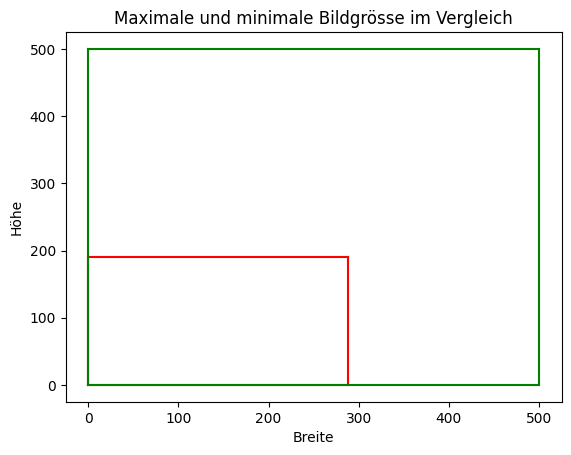

In [16]:
# generate height and width columns
image_dimensions['height'] = image_dimensions.dimension.apply(lambda x: x[1])
image_dimensions['width'] = image_dimensions.dimension.apply(lambda x: x[0])
image_dimensions['area'] = image_dimensions['height'] * image_dimensions['width']

# pick smallest and largest
min_img = image_dimensions[image_dimensions.area == image_dimensions.area.min()]
max_img = image_dimensions[image_dimensions.area == image_dimensions.area.max()]

# create plot
plt.plot([0,0], [0, min_img.height.values[0]], color='red', label='min')
plt.plot([0, min_img.width.values[0]], [min_img.height.values[0], min_img.height.values[0]], color='red', label='min')
plt.plot([min_img.width.values[0], min_img.width.values[0]], [min_img.height.values[0], 0], color='red', label='min')
plt.plot([min_img.width.values[0], 0], [0,0], color='red', label='min')

plt.plot([0,0], [0, max_img.height.values[0]], color='green', label='max')
plt.plot([0, max_img.width.values[0]], [max_img.height.values[0], max_img.height.values[0]], color='green', label='max')
plt.plot([max_img.width.values[0], max_img.width.values[0]], [max_img.height.values[0], 0], color='green', label='max')
plt.plot([max_img.width.values[0], 0], [0,0], color='green', label='max')

# plt.legend()
plt.title("Maximale und minimale Bildgrösse im Vergleich")
plt.xlabel("Breite")
plt.ylabel("Höhe")
plt.show()

Idealerweise haben die Inputbilder eines CNNs die gleiche Grösse. Wie die Grafik oben zeigt, ist dies nicht der Fall. Es gibt mehrere Varianten dieses Problem zu beheben. 

* Die Bilder werden auf die kleinste Bildgrösse zugeschnitten. Dies ist ein guter Ansatz, wenn grosse Bilder zum Training vorhanden sind. Dann gehen weniger Informationen verloren. In diesem Fall würde beim Zuschneiden des grössten Bildes auf die Grösse des kleinsten fast drei Viertel des Bildes verloren gehen.
* Interpolation. Die kleineren Bilder werden mittels Interpolation auf die grössten Bilder skaliert. Dabei gehen keine Informationen verloren und die Bilder haben die gleiche Grösse. 
* Padding. Die Bilder werden mit einem Padding auf die Grösse des grössten Bildes gebracht. Als Padding werden Nullen verwendet. Dieser Ansatz ist vergleichbar mit der Interpolation, da auch hier keine Informationen verloren gehen.

Das Paper von Hashemi: *Enlarging smaller images before inputting into convolutional neural network: zero-padding vs. interpolation* (https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0263-7) zeigte, dass die Methoden ähnliche Ergebnisse liefern. Das Padding von Bildern ist aber signifikant schneller als die Interpolation. Deshalb wird das Padding verwendet.

### Bildaten Preprocessing

Die Bilder werden alle auf die Grösse 500x500 skaliert. Dabei werden kleinere Bilder zentriert und mit Nullen aufgefüllt. 

In [72]:
import torchvision.transforms as T

In [73]:
# center crop images
transform = T.Compose([
    T.CenterCrop((max_img.height.values[0], max_img.width.values[0])),
    T.Resize((224, 224)),
    T.ToTensor()
])

# load images
images = {}
for image_path in image_paths:
    # load image
    image = Image.open("flickr8k/images/" + image_path)
    # transform image
    image = transform(image)
    # add image
    images[image_path] = image
    # check shape
    assert image.shape == (3, 224, 224)

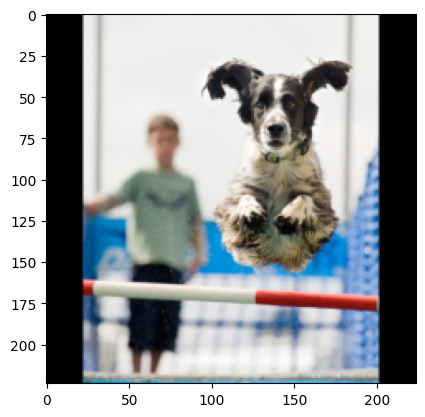

In [79]:
plt.imshow(images[list(images.keys())[3]].permute(1, 2, 0))
plt.show()

### Data Loader

In [313]:
# create dataloader for images and captions
from torch.utils.data import Dataset, DataLoader

class FlickrDataset(Dataset):
    def __init__(self, captions, images, transform=None):
        self.captions = captions
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        # get caption
        caption = self.captions.iloc[idx, 1]
        # get image
        key = self.captions.iloc[idx, 0]
        image = self.images[key]
        # turn string into list
        caption = eval(caption)
        # get length
        length = self.captions.iloc[idx, 2]

        return image, caption, length

#### Testing Data Loader

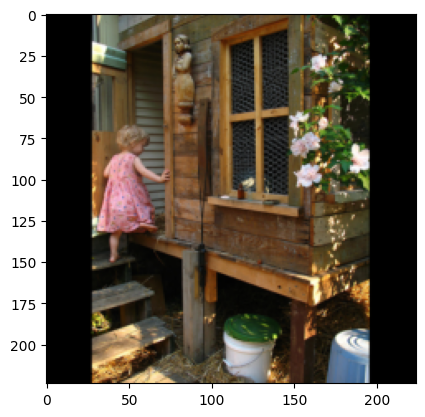

['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '<EOS>', '<PAD>', '<PAD>', '<PAD>']


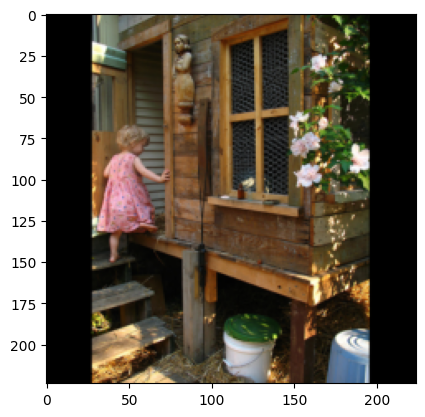

['<SOS>', 'a', 'girl', 'going', 'into', 'a', 'wooden', 'building', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


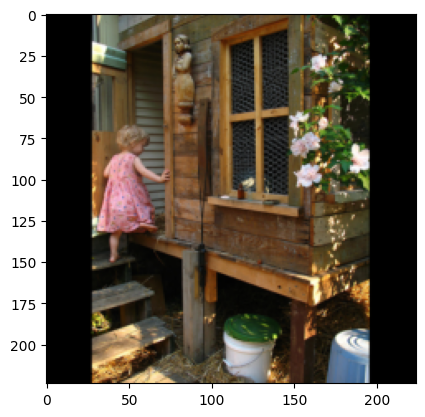

['<SOS>', 'a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


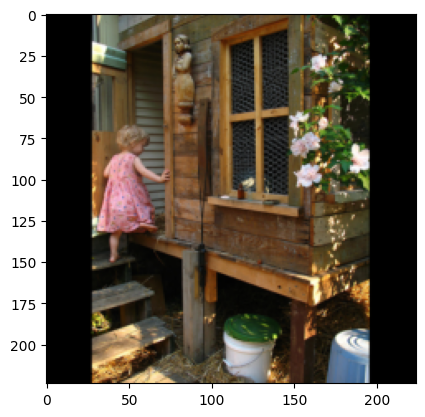

['<SOS>', 'a', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her', 'playhouse', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


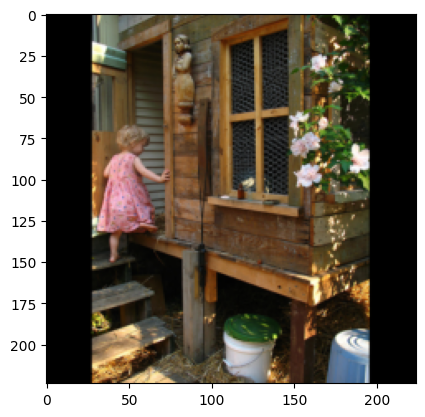

['<SOS>', 'a', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [315]:
flickr_dataset = FlickrDataset(captions=captions_filtered, images=images, transform=transform)

for i, (image, caption, length) in enumerate(flickr_dataset):
    plt.imshow(image.permute(1, 2, 0))
    plt.show()
    print(caption)
    if i > 3:
        break

### Trainings- und Testdaten Split

# Modellstruktur

## EncoderCNN

In [316]:
class EncoderCNN:
    '''
    This class contains the CNN that is used for feature extraction from the images. 
    
    Params:
    -------
        pretrained_net torchvision.models: Determines the pretrained network that is used for feature extraction.
        output_size int: The Outputsize of the last layer of the CNN. This is determined by the dimensions of the embedding matrix. 
    '''
    def __init__(self, net=None, pretrained_weights=None, output_size:int=300):
        self.output_size = output_size
        # load net
        self.net = net(weights=pretrained_weights)
        # replace last layer
        self.net.fc = torch.nn.Linear(in_features=self.net.fc.in_features, out_features=self.output_size, bias=True)
        # send to device
        self.net = self.net.to(device)

    def forward(self, x):
        '''
        Params:
        -------
            x torch.Tensor: The input tensor that is used for feature extraction. Shape: (batch_size, channels, height, width)
        '''
        return self.net(x)

In [317]:
encoder = EncoderCNN(net=torchvision.models.resnext50_32x4d, pretrained_weights=torchvision.models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2, output_size=8669)

In [318]:
encoder.forward(next(iter(flickr_dataset))[0].reshape(1, 3, 224, 224))

tensor([[-0.0127,  0.0027,  0.0175,  ...,  0.1231,  0.0032,  0.0725]],
       grad_fn=<AddmmBackward0>)

## Embedding

In [319]:
class Embedding:
    '''
    This class contains the embedding matrix for the captions. The forward function turns a word into a embedding vector.
    
    Params:
    -------
        embedding_matrix torch.Tensor: The embedding matrix that is used for the forward function.
    '''
    def __init__(self, embedding_matrix, vocabulary):
        self.embedding_matrix = embedding_matrix
        # send to device
        self.vocabulary = vocabulary
        self.embedding_matrix = self.embedding_matrix.to(device)
    
    def caption_to_embedding(self, caption):
        '''
        Params:
        -------
            caption list: A list of words that is turned into a list of embedding vectors.

        Returns:
        --------
            embedding_vectors torch.Tensor: A tensor of embedding vectors. Shape: (len(caption), embedding_size)
        '''
        # turn caption into list of embedding vectors
        embedding = [self.forward(torch.tensor(self.vocabulary[word])) for word in caption]
        # stack embedding vectors
        embedding = torch.stack(embedding)
        # return embedding
        return embedding

    def forward(self, x):
        '''
        Params:
        -------
            x torch.Tensor: The input tensor that is used for embedding. Shape: (batch_size, max_caption_length)
        
        Returns:
        --------
            embedding_vector torch.Tensor: A tensor of a embedding vector.
        '''
        return self.embedding_matrix[x]

In [320]:
glove_embedding = Embedding(embedding_matrix=glove, vocabulary=vocabulary)
assert torch.Size([4, 300]) == glove_embedding.caption_to_embedding(caption=["a", "dog", "is", "running"]).shape

## DecoderRNN

In [321]:
class DecoderRNN:
    '''
    Class for decoding a feature vector into a sequence of words. 
    
    Params:
    -------
        input_size int: The input size of the first layer of the RNN. This is determined by the dimensions of the embedding matrix. 
        hidden_size int: The hidden size of the RNN. Is also determined by the dimensions of the embedding matrix. 
        num_layers int: The number of layers of the RNN. 
        dropout float: The dropout rate of the RNN. 
    '''
    def __init__(self, input_size:int, hidden_size:int, len_vocab:int, num_layers:int=1, dropout:float=0.0):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        # create RNN
        self.rnn = torch.nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, dropout=self.dropout, batch_first=True)
        # send to device
        self.rnn = self.rnn.to(device)
        self.fc = torch.nn.Linear(hidden_size, len_vocab)

    def forward(self, x, hidden):
        '''
        Params:
        -------
            x torch.Tensor: The input tensor that is used for feature extraction. Shape: (batch_size, seq_len, input_size)
            hidden tuple(torch.Tensor, torch.Tensor): The hidden state of the RNN. Shape: (seq_len, batch_size, hidden_size)
        '''
        rnn_output = self.rnn(x, hidden)
        
        return rnn_output

## Modell

In [323]:
class ImageCaptioning:
    '''
    Class for the image captioning model.
    
    Params:
    -------
        encoder EncoderCNN: The encoder that is used for feature extraction.
        decoder DecoderRNN: The decoder that is used for decoding the feature vector into a sequence of words. 
        embedding Embedding: The embedding matrix that is used for embedding the words. 
    '''
    def __init__(self, encoder, decoder, embedding):
        self.encoder = encoder
        self.decoder = decoder
        self.embedding = embedding

        # send submodels to device
        self.encoder.net.to(device)
        self.decoder.rnn.to(device)
        self.embedding.embedding_matrix.to(device)

    def forward_train(self, images, captions):
        '''
        Forward pass through model while using the embedding vectors of the caption as input for the decoder.
        '''
        # extract features
        features = self.encoder.forward(image)
        # turn caption into embedding vectors
        embedding = self.embedding.caption_to_embedding(caption)
        embedding = torch.cat((features, embedding), dim=0)
        embedding = embedding.unsqueeze(1)
        
        print(embedding[1].shape)
        # add batch dimension
        # embedding = embedding.unsqueeze(0)
        # embedding = embedding.permute(1, 0, 2)
        # print(embedding, embedding.shape)
        # print(features, features.shape)        

        # bring embedding into correct shape (seq_len, batch_size, input_size)

        # forward pass through decoder
        output, hidden = self.decoder.forward(features, embedding)
        # return output and hidden state
        return output, hidden

    def forward(self, image):
        pass

In [324]:
encoder = EncoderCNN(net=torchvision.models.resnext50_32x4d, pretrained_weights=torchvision.models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2, output_size=300)
decoder = DecoderRNN(input_size=300, hidden_size=300, num_layers=1, dropout=0.0,len_vocab=8998)
embedding = Embedding(embedding_matrix=glove, vocabulary=vocabulary)
model = ImageCaptioning(encoder=encoder, decoder=decoder, embedding=embedding)

In [326]:
next(iter(flickr_dataloader))

NameError: name 'flickr_dataloader' is not defined

In [ ]:
flickr